In [1]:
import os, time, copy, glob, cv2, shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

In [2]:
data_path = 'c:/chatbot/python/pythorch/data/catanddog'

transform = transforms.Compose(
    [
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.ImageFolder(
    data_path, transform=transform,
)

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True
)

print(len(train_dataset))

483


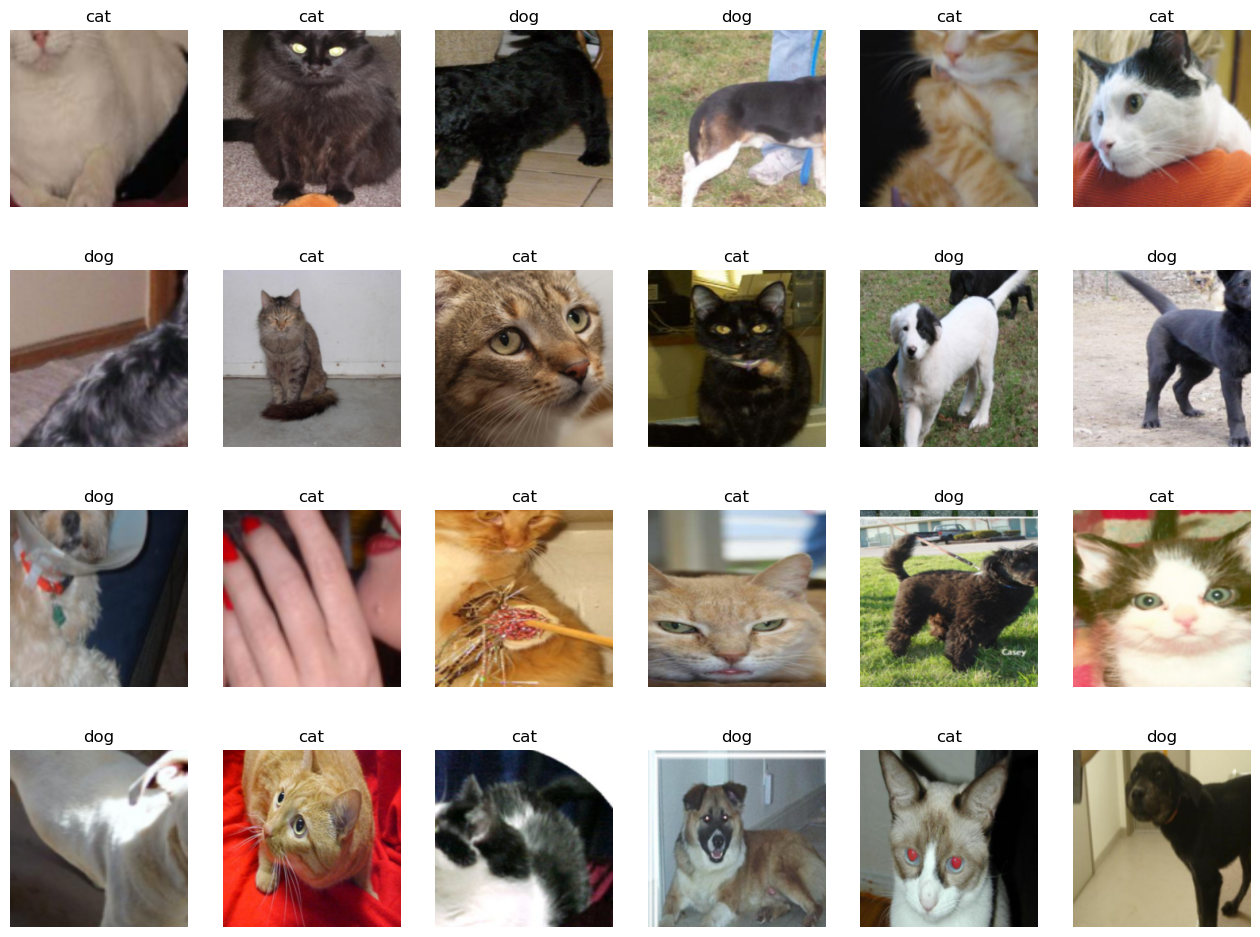

In [3]:
samples, labels = train_loader._get_iterator()._next_data()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    fig.add_subplot(4, 6, i+1)
    plt.title(classes[labels[i].item()])
    plt.axis('off')
    plt.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


In [4]:
resnet18 = models.resnet18(pretrained=True)

c:\Users\admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [6]:
resnet18.fc = nn.Linear(512, 2)

In [7]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0369, -0.0188,  0.0243,  ...,  0.0065,  0.0277,  0.0312],
        [ 0.0188, -0.0372, -0.0140,  ..., -0.0440,  0.0192, -0.0331]])
fc.bias tensor([0.0138, 0.0318])


In [8]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13,
                is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            inbels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs,1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('c:/chatbot/python/pythorch/data/catanddog',
                    '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
            time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [12]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion,
                                              optimizer, device)

Epoch 0/12
----------
Loss: 0.6044 Acc: 0.6605

Epoch 1/12
----------
Loss: 0.3529 Acc: 0.8592

Epoch 2/12
----------
Loss: 0.2729 Acc: 0.9110

Epoch 3/12
----------
Loss: 0.2241 Acc: 0.9110

Epoch 4/12
----------
Loss: 0.2024 Acc: 0.9213

Epoch 5/12
----------
Loss: 0.1930 Acc: 0.9255

Epoch 6/12
----------
Loss: 0.2103 Acc: 0.9151

Epoch 7/12
----------
Loss: 0.2149 Acc: 0.9027

Epoch 8/12
----------
Loss: 0.1970 Acc: 0.9130

Epoch 9/12
----------
Loss: 0.1915 Acc: 0.9213

Epoch 10/12
----------
Loss: 0.1995 Acc: 0.9213

Epoch 11/12
----------
Loss: 0.1846 Acc: 0.9234

Epoch 12/12
----------
Loss: 0.1855 Acc: 0.9213

Training complete in 4m 38s
Best Acc: 0.925466


In [15]:
test_path = 'c:/chatbot/python/pythorch/data/catanddog'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

483


In [26]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('c:/chatbot/python/pythorch/data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
            time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history
    

In [28]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['c:/chatbot/python/pythorch/data/catanddog\\00.pth', 'c:/chatbot/python/pythorch/data/catanddog\\01.pth', 'c:/chatbot/python/pythorch/data/catanddog\\02.pth', 'c:/chatbot/python/pythorch/data/catanddog\\03.pth', 'c:/chatbot/python/pythorch/data/catanddog\\04.pth', 'c:/chatbot/python/pythorch/data/catanddog\\05.pth', 'c:/chatbot/python/pythorch/data/catanddog\\06.pth', 'c:/chatbot/python/pythorch/data/catanddog\\07.pth', 'c:/chatbot/python/pythorch/data/catanddog\\08.pth', 'c:/chatbot/python/pythorch/data/catanddog\\09.pth', 'c:/chatbot/python/pythorch/data/catanddog\\10.pth', 'c:/chatbot/python/pythorch/data/catanddog\\11.pth', 'c:/chatbot/python/pythorch/data/catanddog\\12.pth']
Loading model c:/chatbot/python/pythorch/data/catanddog\00.pth
Acc: 0.8592

Loading model c:/chatbot/python/pythorch/data/catanddog\01.pth
Acc: 0.9607

Loading model c:/chatbot/python/pythorch/data/catanddog\02.pth
Acc: 0.9586

Loading model c:/chatbot/python/pythorch/data/catanddog\03.pth
Acc: 0.

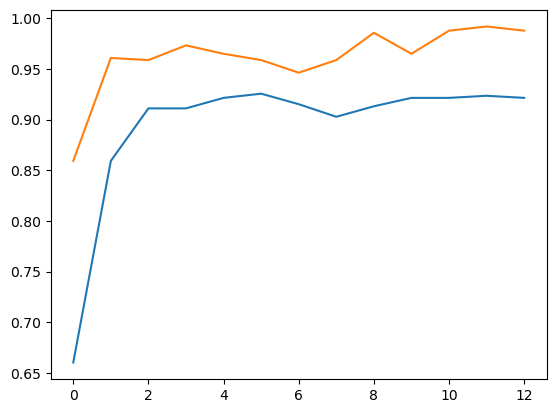

In [29]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()


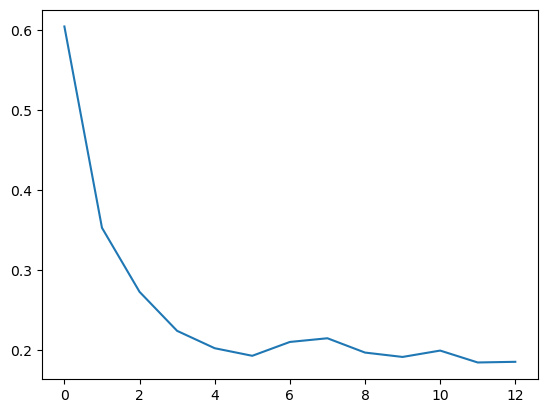

In [30]:
plt.plot(train_loss_hist)
plt.show()

In [31]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
    image = image.clip(0,1)
    return image

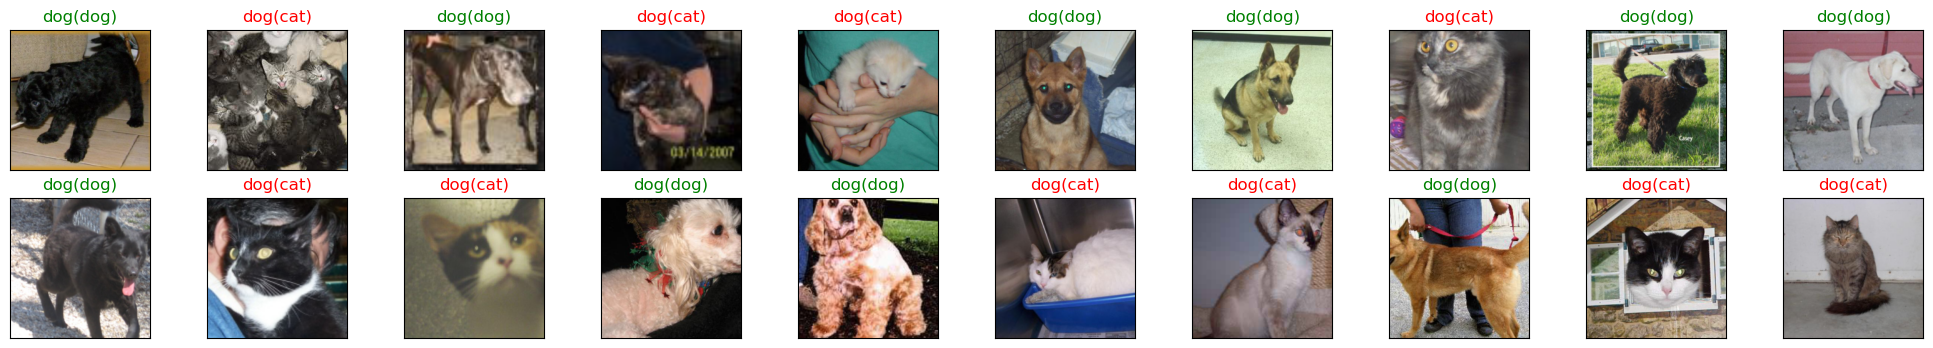

<Figure size 640x480 with 0 Axes>

In [33]:
classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].
            item()])), color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)   